# Imports

In [3]:
import re
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [4]:
sns.set(rc={'figure.figsize':(24,16)})
sns.set_style("ticks")
sns.set_context('notebook', font_scale=2.5)

# Latent Dirichlet Allocation

## Functions

In [4]:
def print_top_words(model, feature_names, names, n_top_words=10):
    ''' Print top words for each LDA class and name associated to that class '''
    
    for i, topic in enumerate(model.components_):
        message = names[i] + ':\n   '
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

## Results

In [5]:
insta1 = pd.read_csv('instagram_1.csv')

In [15]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(insta1['hashtags'].tolist())

In [52]:
K = 20
names = ['Fitness', 'Instagram daily', 'Footing', 'Drawing', 'Japanese visitors',
         'Beard', 'Hair & Decoration', 'Visit Switzerland', 'LGBT', 'Instagram followers',
         'Travelling in Swizerland', 'Arabian visitors','Black&White', 'Food', 'Planes', 
         'Horseback riding','Switzerland', 'Toilets', 'Instagram likes', 'Music']

lda = LatentDirichletAllocation(n_components=K, max_iter=10, learning_method='online', 
                                learning_offset=50., random_state=0)
lda.fit(X)
print('===== LDA model with ' + str(K) + ' topics =====\n')
feature_names = vectorizer.get_feature_names()
print_top_words(lda, feature_names, names)

===== LDA model with 20 topics =====

Fitness:
   fitness gym fit workout eatclean motivation healthy zürich fitfam zurich
Instagram daily:
   switzerland instagood picoftheday instamood igerssuisse photooftheday igers instagramhub bestoftheday instadaily
Footing:
   sneakers und runway repost forever du letzigrund jordan nike cully
Drawing:
   art tattoo artist dubai switzerland creative drawing london draw pencil
Japanese visitors:
   스위스 여행 유럽 여행스타그램 유럽여행 travel interlaken europe daily swiss
Beard:
   beard bearded beardporn instabeard university bowtie happyweekend student cindy charity
Hair & Decoration:
   decoration interior handmade deco gold hair home vintage haircolor haircut
Visit Switzerland:
   switzerland visitswitzerland mountains nature swissalps alps schweiz landscape myswitzerland switzerlandwonderland
LGBT:
   nails gay instagay nailart gayfollow naildesign gayguy gaybeard gaylife matt
Instagram followers:
   follow followme instagood love photooftheday like4like pic

## Comments
The clusters obtained by LDA are very relevant. Even if some words sometimes seem odd, such as the presence of the hashtag "fitfood" in the class "Arabian visitors", they remain a minority and do not make the meaning of the cluster doubtful or confused. Several subjects are quite surprising, first of all the presence of a Toilets cluster, which nevertheless seems quite correct. Among the other amazing classes, the presence of a separate class for Arabic-speaking tourists, and another for Japanese tourists. Let us also mention the presence of a separate class for equestrian sports, or even for beards. The class that seems the most surprising at the association level is the class gathering gay tags and nailart, two very different topics, which could possibly be linked by a link with transgenrism.

All the themes covered here remain very artistic or visual, we mainly count leisure (music, fitness, jogging, planes), aesthetic subjects (drawings, Black&White, decoration, hair, beard), travellers (arabian, japanese, visit Switzerland), and subjects directly related to Instagram (instagram daily, instagram likes, instagram followers).

The LDA algorithm can only capture nuances as effectively with a sufficiently large dataset. With a smaller dataset, we would probably see several topics grouped into larger categories, such as those described above. However, if the dataset becomes too small, the LDA will simply no longer be able to "understand" the meaning of the words.

The presence of these tags that are very much focused on common interests and hobbies also helps to create communities on Instagram. These communities are oriented towards visual or artistic subjects, in which the image plays a greater role.

# RandomForest
## Functions

In [5]:
def print_top(df, label='alcohol', column='tags'):
    ''' Print the top 30 values for the selected column and label '''

    keys = df[column][0].keys()
    
    dico = {}
    for key in keys:
        dico[key] = 0

    for ind, item in df[df['label'] == label][column].iteritems():
        for key in keys:
            dico[key] += item[key]
    
    top30 = pd.Series(dico).sort_values(ascending = False)[:30].sort_values(ascending = True)
    ax = top30.plot(kind='barh', title='Top 30 ' + column + ' for ' + label + ' class\n')
    ax.set_xlabel('Sum of occurences')

In [6]:
def confusion(pred, y):
    ''' Compute true positive, false positive, true negative and false negative
        out of predicted and actual outcome '''
    
    df = pd.DataFrame({'pred': pred, 'y': y})
    tp = len(df[(df['pred'] == 1) & (df['y'] == 1)])
    tn = len(df[(df['pred'] == 0) & (df['y'] == 0)])
    fp = len(df[(df['pred'] == 1) & (df['y'] == 0)])
    fn = len(df[(df['pred'] == 0) & (df['y'] == 1)])
    
    return  tp, fp, tn, fn

In [7]:
def score(tp, fp, tn, fn):
    ''' Compute score metrics '''
    
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    return accuracy, precision, recall

In [17]:
def rfc_prediction(df, column, max_depth=2):
    ''' Train a RFC and evaluate its performance '''
    
    # Transform the dict found in each cell into a matrix of values 
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(df[column])
    
    # Convert labels into binary values
    y = pd.get_dummies(df['label'])['alcohol'].values
    
    # Create cross-validation sets
    X, y = shuffle(X, y, random_state=349)
    X_train, X_test, y_train, y_test = [], [], [], []
    skf = StratifiedKFold(n_splits=10, shuffle=False, random_state=53)
    
    for train_index, test_index in skf.split(X, y):
        X_train.append(X[train_index])
        X_test.append(X[test_index])
        y_train.append(y[train_index])
        y_test.append(y[test_index])
    
    accuracy, precision, recall = [], [], []

    # Perform cross-validated RandomForest
    for i in range(10):

        # Train and test RandomForest
        rfc = RandomForestClassifier(n_estimators=100, max_depth=max_depth,random_state=0)
        rfc.fit(X_train[i], y_train[i])
        pred = rfc.predict(X_test[i])

        # Compute and store score metrics
        tp, fp, tn, fn = confusion(pred, y_test[i])
        acc, prec, rec = score(tp, fp, tn, fn)
        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)

    # Put score metric in a table
    res = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall'],
                            'Mean': [np.mean(accuracy), np.mean(precision), np.mean(recall)]})
    res.index = res['Metric']
    res = res.drop(columns = 'Metric')

    return res

## Results

In [9]:
df = pd.read_json('instagram_2.json', lines=True)

In [10]:
df.head(5)

,_id,imgfeatures,label,tags
0,{'$oid': '5cd2d3c2c03b40d4f2d216dd'},"{'pedestal, plinth, footstall': 5e-05, 'entert...",alcohol,"{'raclette': 0, 'blackandwhite': 0, 'starbucks..."
1,{'$oid': '5cd2d3c2c03b40d4f2d216de'},"{'pedestal, plinth, footstall': 2e-05, 'entert...",alcohol,"{'raclette': 0, 'blackandwhite': 0, 'starbucks..."
2,{'$oid': '5cd2d3c2c03b40d4f2d216df'},"{'pedestal, plinth, footstall': 0.0, 'peacock'...",nonalcohol,"{'raclette': 0, 'blackandwhite': 0, 'starbucks..."
3,{'$oid': '5cd2d3c2c03b40d4f2d216e0'},"{'pedestal, plinth, footstall': 0.000130000000...",alcohol,"{'raclette': 0, 'blackandwhite': 0, 'starbucks..."
4,{'$oid': '5cd2d3c2c03b40d4f2d216e1'},"{'pedestal, plinth, footstall': 7.000000000000...",alcohol,"{'raclette': 0, 'blackandwhite': 0, 'starbucks..."


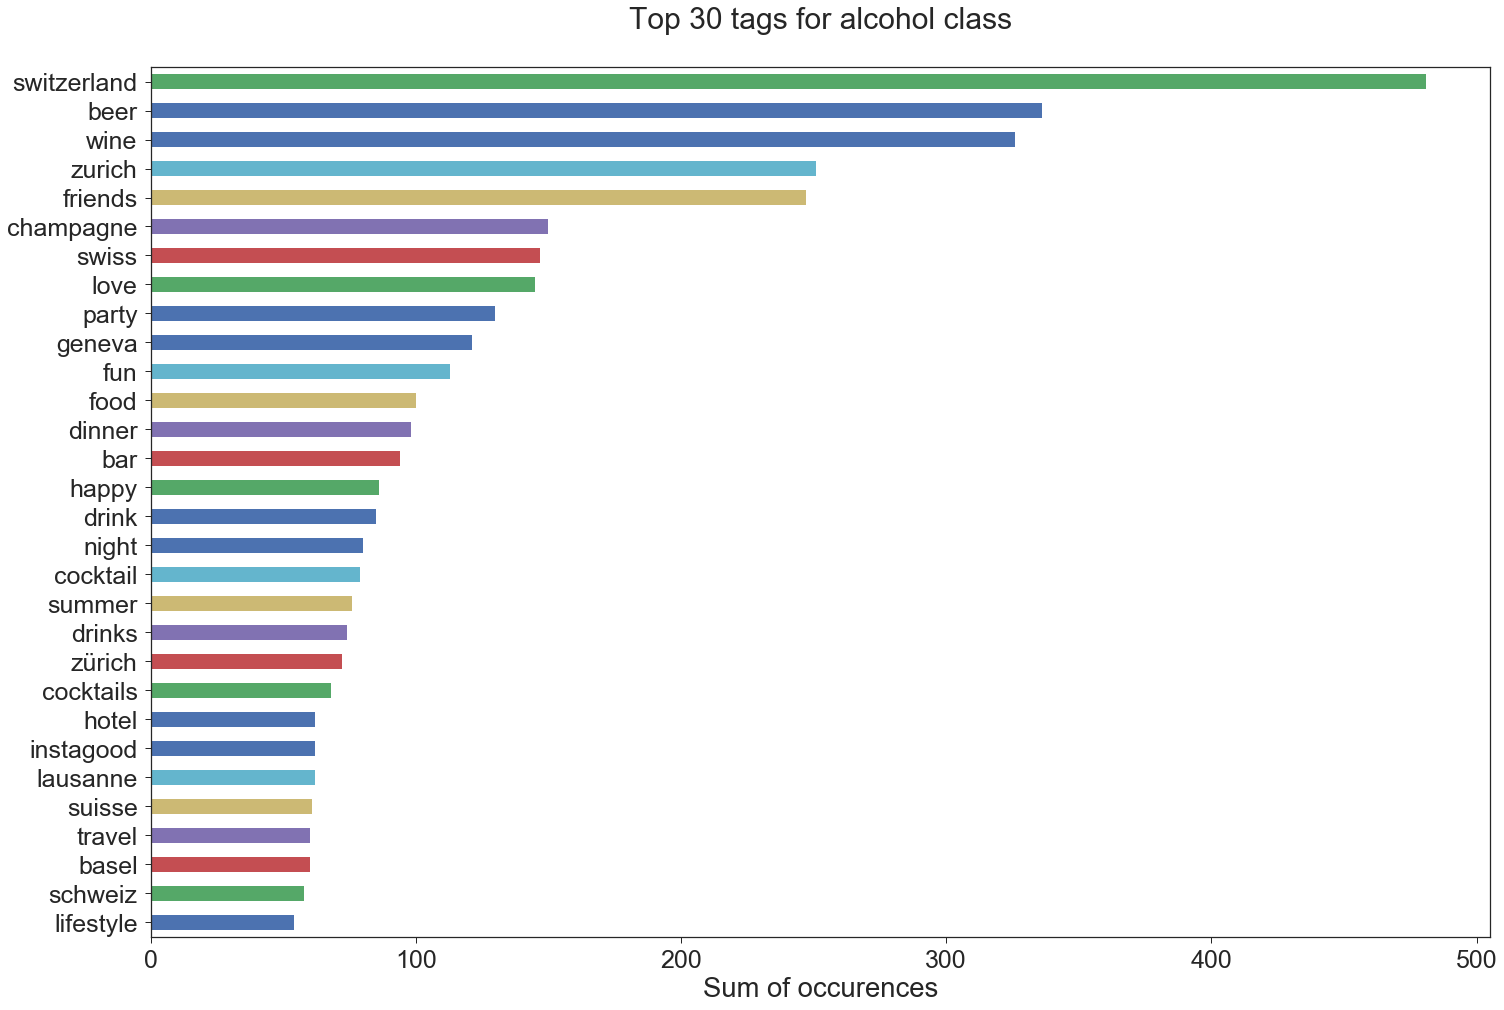

In [11]:
print_top(df, 'alcohol', 'tags')

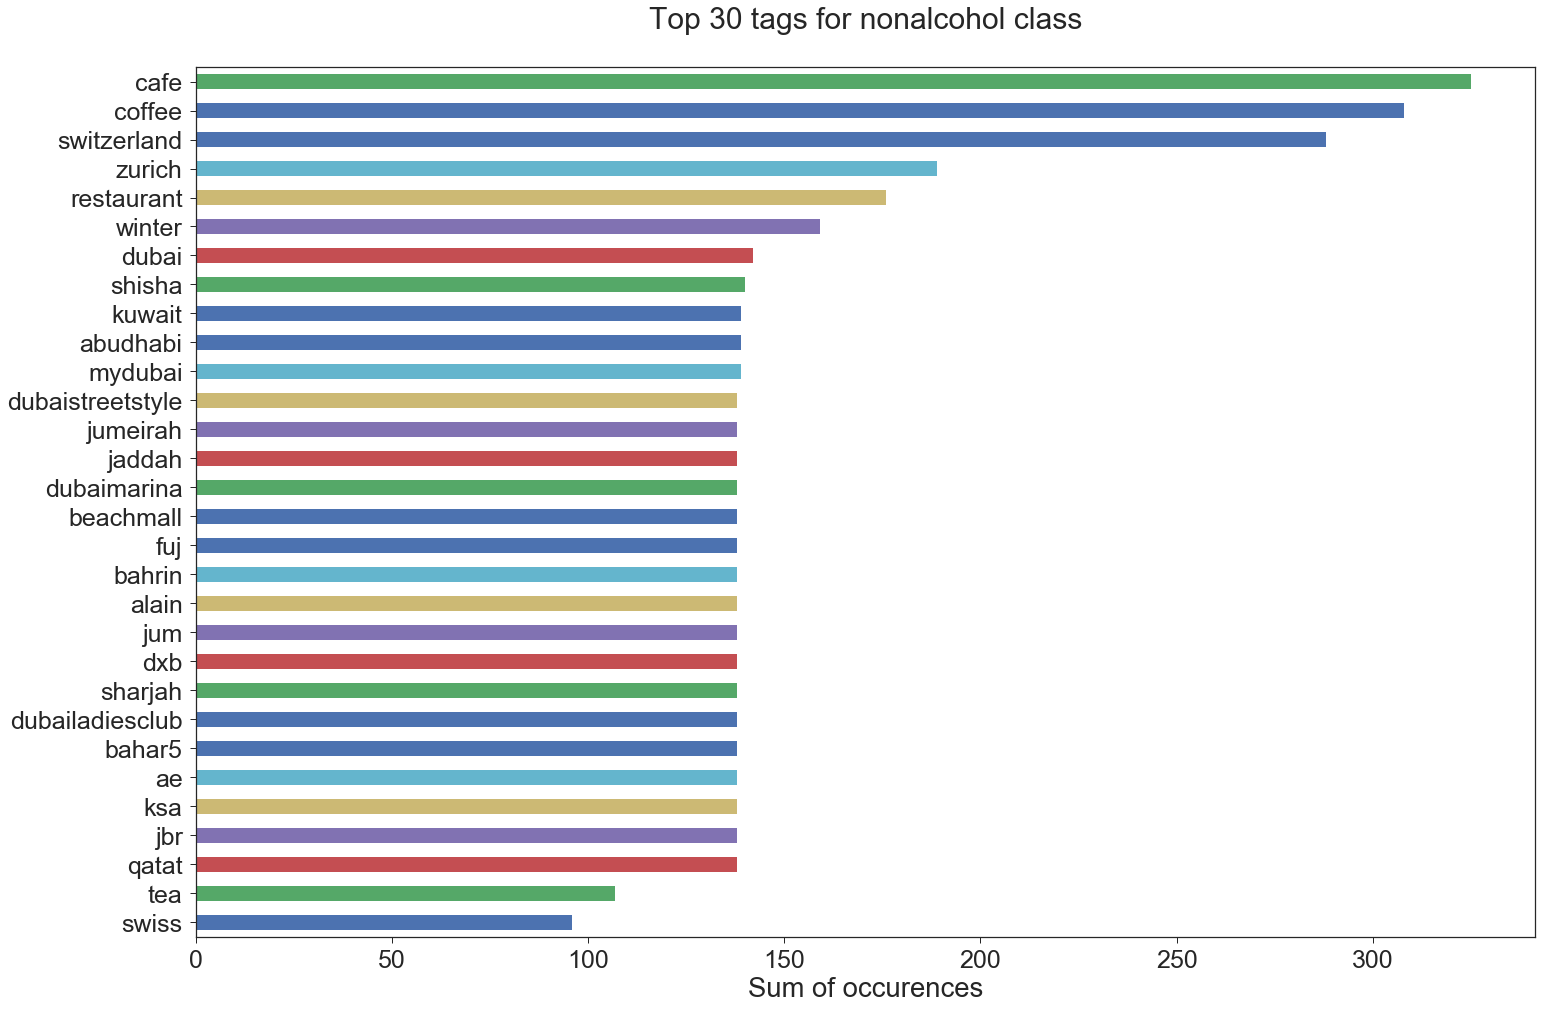

In [12]:
print_top(df, 'nonalcohol', 'tags')

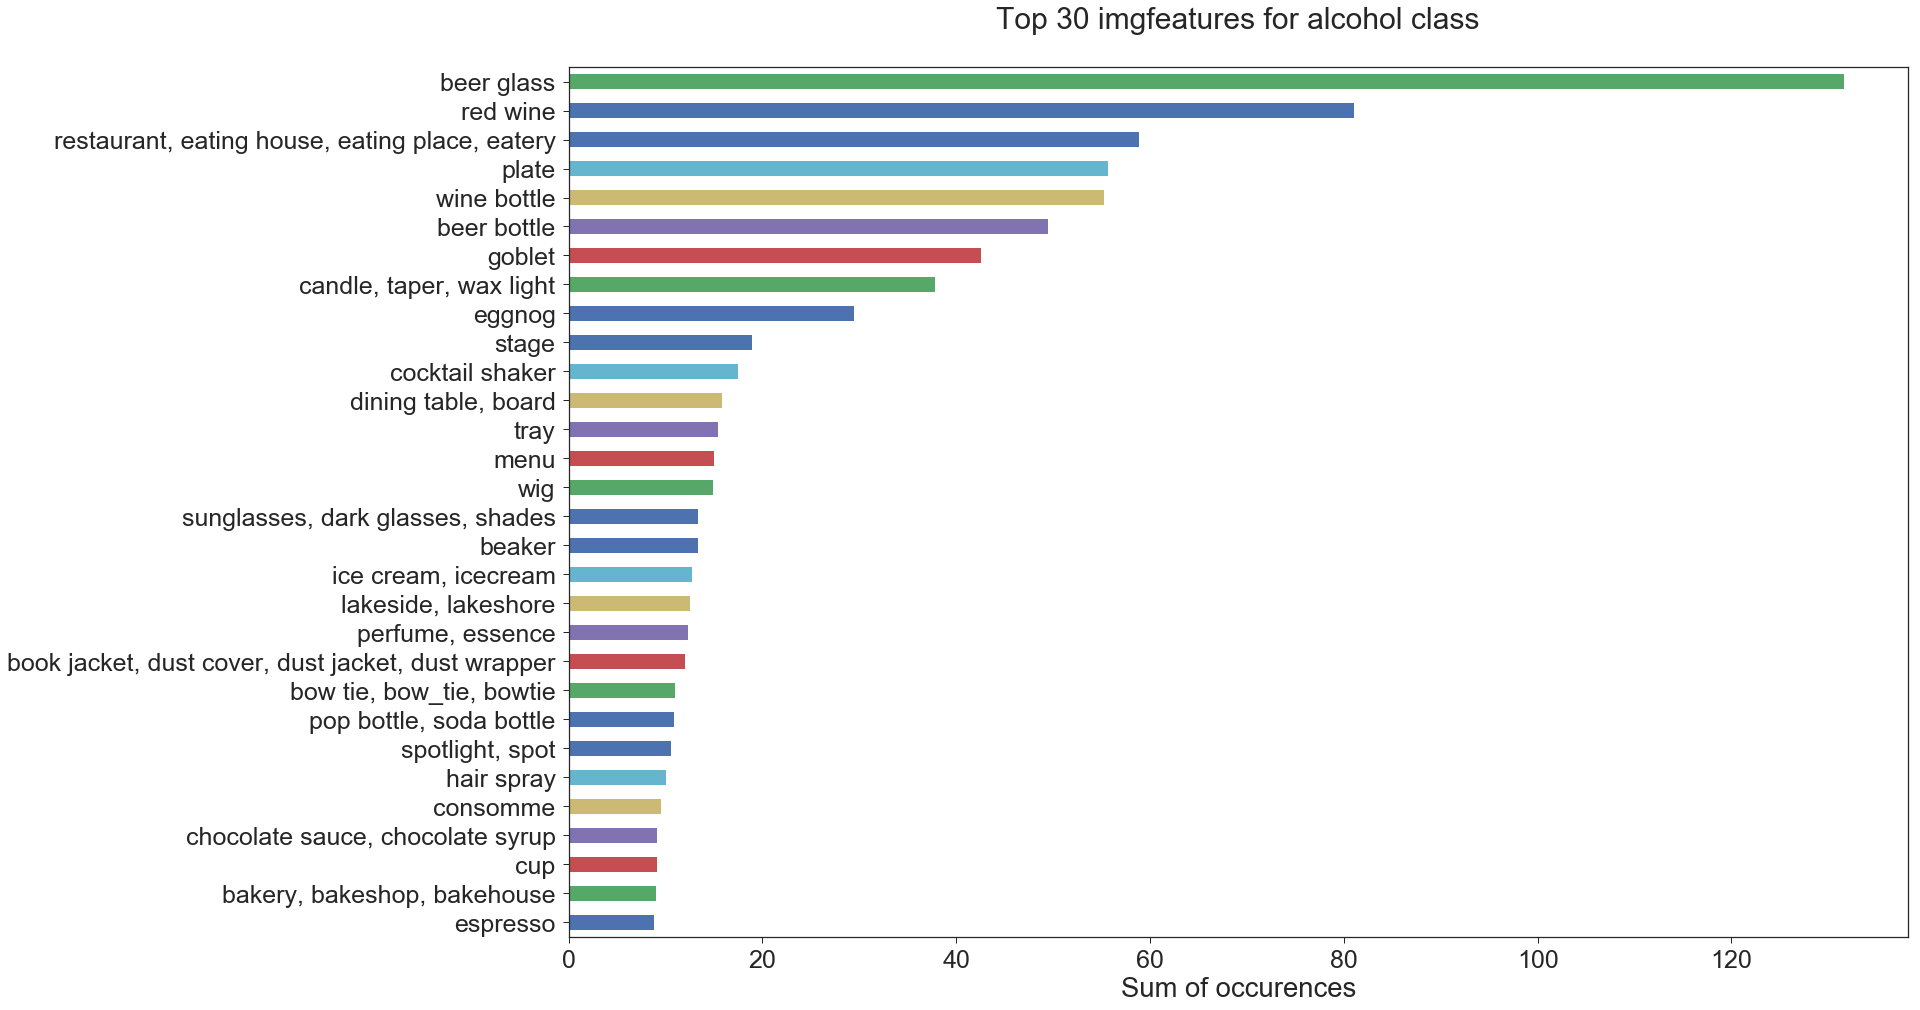

In [13]:
print_top(df, 'alcohol', 'imgfeatures')

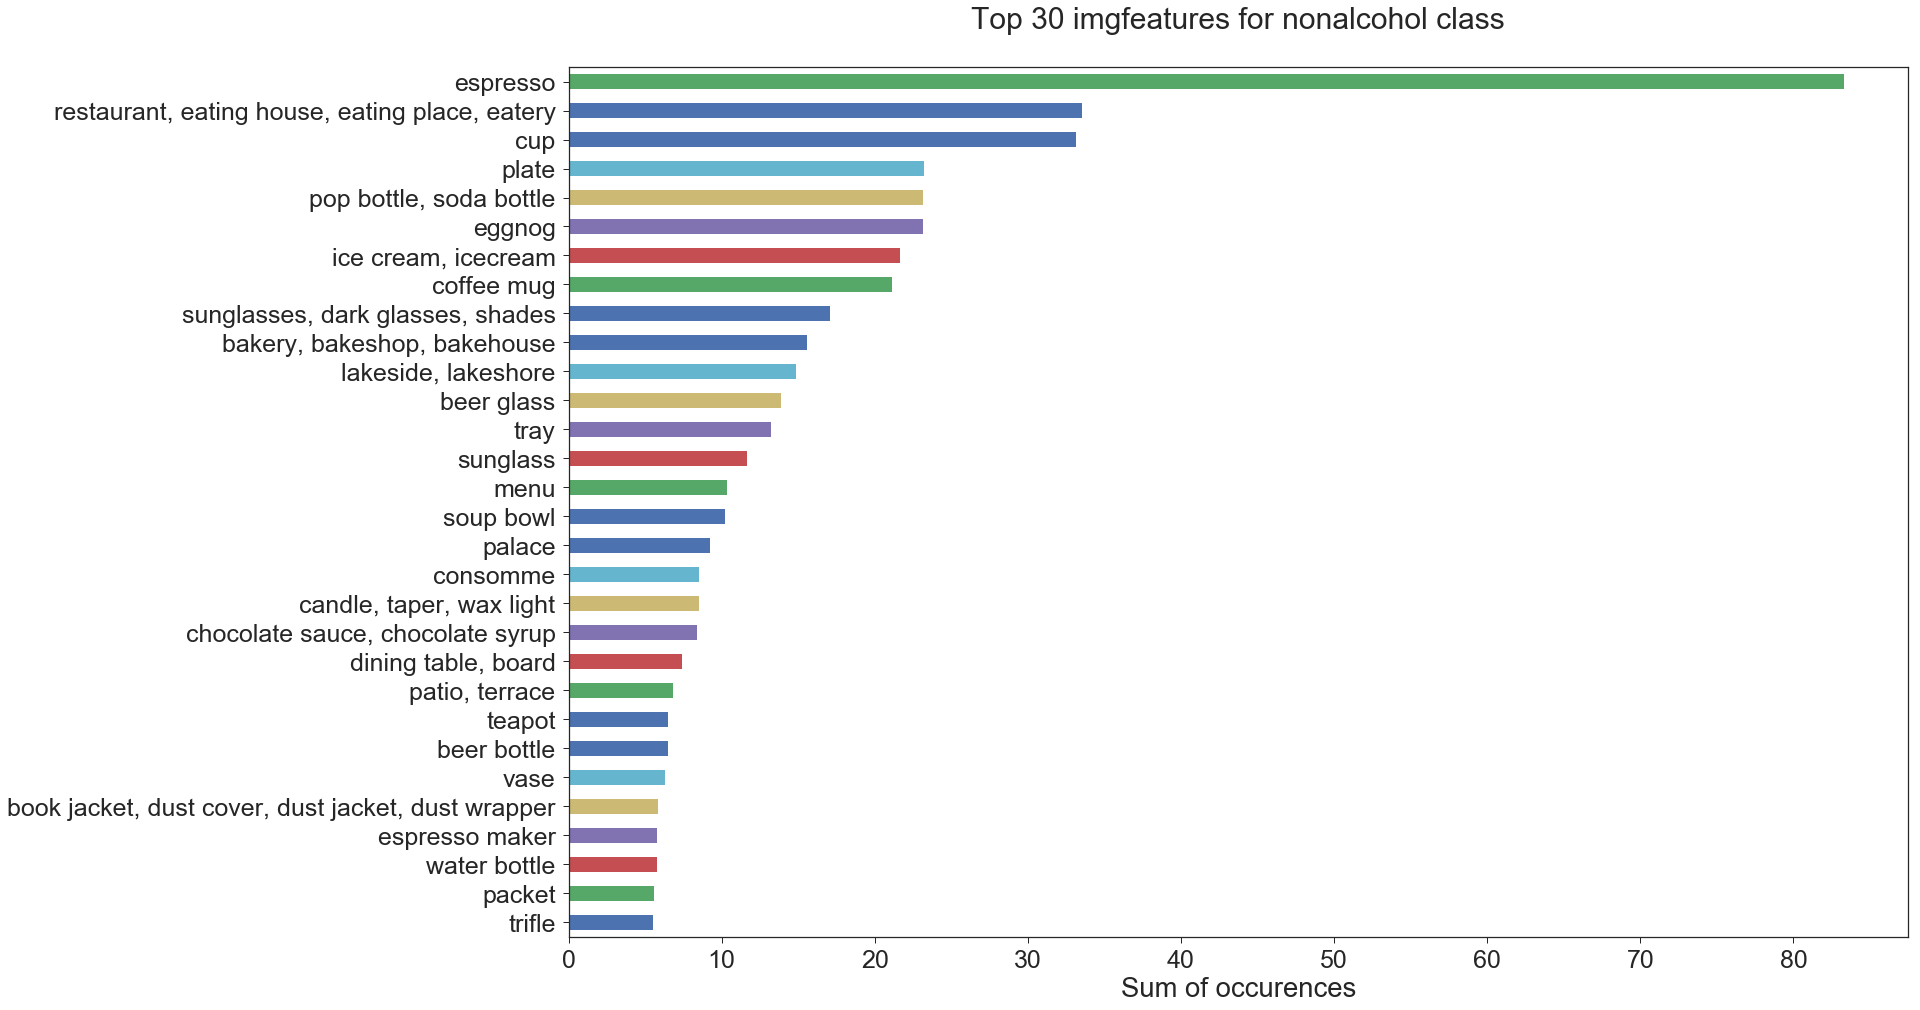

In [14]:
print_top(df, 'nonalcohol', 'imgfeatures')

In [18]:
rfc_prediction(df, 'tags')

,Mean
Metric,
Accuracy,0.677332
Precision,0.659240
Recall,1.000000


In [19]:
rfc_prediction(df, 'imgfeatures')

,Mean
Metric,
Accuracy,0.676003
Precision,0.658460
Recall,0.999465


## Comments

To apply the Random Forest Classifier, the alcohol/nonalcohol variable is transformed into a binary variable, which represents the class. The other factors are also transformed into an X matrix of purely numerical values. The set is then randomly mixed and divided into 10 K-folds. Thanks to these, a cross-validation is carried out on the Random Forest Classifier. The latter is composed of 100 decision trees with a maximum depth of 2, and the quality of the prediction is assessed by means of precision, recall and accuracy.

The classification works slightly better with imgfeatures. The classification task seems easy because Random Forest remains a relatively simple and fast algorithm, and the maximum depth in this experiment was only two, which means that each decision tree has only 2 branches to choose from. With this depth, there are already no false negatives left, which means that no image has been misclassified as nonalcohol while it was alcohol. Conversely, nearly a third of images classified as alcohol are wrongly classified, as confirmed by the accuracy of about 0.66. This type of misclassification is a false positive. This means that it is more difficult to classify nonalcoholic images than alcoholic images. Just out of curiosity, I also performed the same test with a different maximum depth than the one recommended (see below), which gives much better results. The prediction concerning imgfeatures in particular is becoming very good, at the level of the three metrics. This confirms that this variable is indeed more predictive. This also implies that only about twenty (it may be higher because not all decision trees necessarily select the same branches) elements of the image are sufficient to make an almost perfect prediction. It should be noted that the performances were relatively high with a depth of only 2, which seems logical, because simple elements, such as a beer mug, can be enough to classify an alcohol image.

First of all, we notice that the tags of the two top 30 overlap (such as Switzerland, which appears in the top three in both cases). This already reveals the limitations of this kind of representation. A representation with the most predictive words on both sides would prevent very present tags, such as Switzerland, from blurring the results. Some tag series can also bias the prediction, due to the dataset, as is the case for all the many tags related to Dubai, in the nonalcohol class.

In [25]:
df_1 = rfc_prediction(df, 'tags', max_depth = 1).rename(columns = {'Mean': 'Depth '+str(1)})
for max_depth in range(1,12):
    df_1['Depth '+str(max_depth)] = rfc_prediction(df, 'tags', max_depth = max_depth)['Mean']
df_1

,Depth 1,Depth 2,Depth 3,Depth 4,Depth 5,Depth 6,Depth 7,Depth 8,Depth 9,Depth 10,Depth 11,Depth 12,Depth 13,Depth 14,Depth 15,Depth 16,Depth 17,Depth 18,Depth 19,Depth 20
Metric,,,,,,,,,,,,,,,,,,,,
Accuracy,0.669996,0.677332,0.684334,0.698660,0.710989,0.722322,0.737664,0.763320,0.777986,0.805987,0.824656,0.840645,0.853995,0.869323,0.881324,0.885662,0.900663,0.910664,0.917993,0.924323
Precision,0.654167,0.659240,0.664195,0.674577,0.683770,0.692357,0.704328,0.726110,0.738933,0.764636,0.783256,0.799579,0.814258,0.831361,0.846077,0.851618,0.869637,0.882559,0.892630,0.901427
Recall,1.000000,1.000000,1.000000,0.999465,0.999465,0.999465,0.999465,0.997861,0.997326,0.996257,0.995187,0.994652,0.993048,0.992519,0.990915,0.989848,0.989851,0.988781,0.987712,0.987177


In [23]:
df_2 = rfc_prediction(df, 'imgfeatures', max_depth = 1).rename(columns = {'Mean': 'Depth '+str(1)})
for max_depth in range(1,12):
    df_2['Depth '+str(max_depth)] = rfc_prediction(df, 'imgfeatures', max_depth = max_depth)['Mean']
df_2

,Depth 1,Depth 2,Depth 3,Depth 4,Depth 5,Depth 6,Depth 7,Depth 8,Depth 9,Depth 10,Depth 11,Depth 12,Depth 13,Depth 14
Metric,,,,,,,,,,,,,,
Accuracy,0.624001,0.676003,0.714335,0.756994,0.819663,0.865999,0.888674,0.909665,0.921342,0.929345,0.939664,0.840645,0.853995,0.869323
Precision,0.624001,0.658460,0.686574,0.720980,0.778936,0.826392,0.851313,0.876827,0.893716,0.903922,0.918895,0.799579,0.814258,0.831361
Recall,1.000000,0.999465,0.998399,0.997329,0.994664,0.996260,0.996262,0.995728,0.993054,0.993051,0.991450,0.994652,0.993048,0.992519
